In [ ]:
!pip install --upgrade datasets
!pip install tqdm
!pip install rouge

from sklearn.metrics.pairwise import cosine_similarity
from datasets import Dataset, DatasetDict, load_dataset
from huggingface_hub import login
from tqdm import tqdm
from sklearn.metrics import cohen_kappa_score
from rouge import Rouge
from scipy.stats import pearsonr

import json
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import random
import re
import seaborn as sns
import scipy.stats as stats

base = '-self'
core_dataset_name = 'alqa'

In [ ]:
dataset_gemma = load_dataset("Ramitha/" + core_dataset_name + "-multi-embeddings-results-40-gemma" + base)
df_gemma = pd.DataFrame(dataset_gemma['rawcases'])
dataset_llama = load_dataset("Ramitha/" + core_dataset_name + "-multi-embeddings-results-40-llama" + base)
df_llama = pd.DataFrame(dataset_llama['rawcases'])
dataset_falcon = load_dataset("Ramitha/" + core_dataset_name + "-multi-embeddings-results-40-falcon" + base)
df_falcon = pd.DataFrame(dataset_falcon['rawcases'])
dataset_mistral = load_dataset("Ramitha/" + core_dataset_name + "-multi-embeddings-results-40-mistral" + base)
df_mistral = pd.DataFrame(dataset_mistral['rawcases'])

In [ ]:
def search_problem_space(problem_space, question, temperature, embedding_variation):
    for problem_instance in problem_space:
        if problem_instance["question"] == question and problem_instance["temperature"] == temperature and problem_instance["problem_embedding_variation"] == embedding_variation:
            return problem_instance

def search_answer_space(answer_space, question, temperature, embedding_variation):
    for answer_instance in answer_space:
        if answer_instance["question"] == question and answer_instance["temperature"] == temperature and answer_instance["answer_embedding_variation"] == embedding_variation:
            return answer_instance

def get_weighted_case_alignment(case_embs, case_base):
    emb1, emb2 = case_embs
    emb1 = emb1.reshape(1, -1) if emb1.ndim == 1 else emb1
    emb2 = emb2.reshape(1, -1) if emb2.ndim == 1 else emb2

    alignment_scores = []
    weights = []
    for past_case in case_base:
        past_prob_emb, past_solution_emb = past_case
        past_prob_emb = past_prob_emb.reshape(1, -1) if past_prob_emb.ndim == 1 else past_prob_emb
        past_solution_emb = past_solution_emb.reshape(1, -1) if past_solution_emb.ndim == 1 else past_solution_emb
        prob_similarity = cosine_similarity(emb1, past_prob_emb)[0][0]
        solution_similarity = cosine_similarity(emb2, past_solution_emb)[0][0]
        alignment_score = (prob_similarity + solution_similarity) / 2.0
        alignment_scores.append(alignment_score)
        weights.append(prob_similarity)
    total_weight = sum(weights)
    if total_weight == 0:
        return 0
    normalized_weights = [w / total_weight for w in weights]
    weighted_alignment_score = sum(a * w for a, w in zip(alignment_scores, normalized_weights))
    return weighted_alignment_score

GEMMA AS A MODEL

In [ ]:
df_gemma_temps = df_gemma['temperature'].unique().tolist()
df_gemma_emb_variation = df_gemma['embedding_variation'].unique().tolist()
questions = df_gemma['question'].unique().tolist()
df_gemma_problem_space = []
df_gemma_answer_space = []

for index, row in df_gemma.iterrows():
    problem_instance = {"question": row["question"], "temperature": row["temperature"], "problem_embedding_variation": row["embedding_variation"], "question_emb": row["question_emb"],
                        "reverse_questions": [row["question_answerGenerated_falcon_emb"], row["question_answerGenerated_llama_emb"], row["question_answerGenerated_mistral_emb"]],
                        "gold_standard_cos": row["gold_standard_cos"]
                        }
    df_gemma_problem_space.append(problem_instance)
    solution_instance = {"question": row["question"], "temperature": row["temperature"], "answer_embedding_variation": row["embedding_variation"], "answerGenerated_emb": row["answerGenerated_emb"],
                        "reverse_answers": [row["reverse_answer_answerGenerated_falcon_emb"], row["reverse_answer_answerGenerated_llama_emb"], row["reverse_answer_answerGenerated_mistral_emb"]]
                         }
    df_gemma_answer_space.append(solution_instance)

results = []
for embedding_variation_1 in tqdm(df_gemma_emb_variation, desc="calculating"):
    for embedding_variation_2 in df_gemma_emb_variation:
        value_gold_standard = []
        value_ilralign = []
        for question in questions:
            for temperature in df_gemma_temps:
                obj = search_problem_space(df_gemma_problem_space, question, temperature, embedding_variation_1)
                obj_answer = search_answer_space(df_gemma_answer_space, question, temperature, embedding_variation_2)
                obj.update(obj_answer)

                case_ = [np.array(json.loads(obj["question_emb"])), np.array(json.loads(obj["answerGenerated_emb"]))]
                case_base = [
                    [np.array(json.loads(obj["reverse_questions"][0])), np.array(json.loads(obj["reverse_answers"][0]))],
                    [np.array(json.loads(obj["reverse_questions"][1])), np.array(json.loads(obj["reverse_answers"][1]))],
                    [np.array(json.loads(obj["reverse_questions"][2])), np.array(json.loads(obj["reverse_answers"][2]))]
                ]
                WILRAlign = get_weighted_case_alignment(case_, case_base)
                value_ilralign.append(WILRAlign)
                value_gold_standard.append(obj["gold_standard_cos"])
        corr, p_value = pearsonr(value_gold_standard, value_ilralign)
        results.append({"problem_emb_variation": embedding_variation_1, "answer_emb_variation": embedding_variation_2, "correlation": corr})

df_gemma_results = pd.DataFrame(results)
df_gemma_results

LLAMA AS A MODEL

In [ ]:
df_llama_temps = df_llama['temperature'].unique().tolist()
df_llama_emb_variation = df_llama['embedding_variation'].unique().tolist()
questions = df_llama['question'].unique().tolist()
df_llama_problem_space = []
df_llama_answer_space = []

for index, row in df_llama.iterrows():
    problem_instance = {"question": row["question"], "temperature": row["temperature"], "problem_embedding_variation": row["embedding_variation"], "question_emb": row["question_emb"],
                        "reverse_questions": [row["question_answerGenerated_falcon_emb"], row["question_answerGenerated_gemma_emb"], row["question_answerGenerated_mistral_emb"]],
                        "gold_standard_cos": row["gold_standard_cos"]
                        }
    df_llama_problem_space.append(problem_instance)
    solution_instance = {"question": row["question"], "temperature": row["temperature"], "answer_embedding_variation": row["embedding_variation"], "answerGenerated_emb": row["answerGenerated_emb"],
                        "reverse_answers": [row["reverse_answer_answerGenerated_falcon_emb"], row["reverse_answer_answerGenerated_gemma_emb"], row["reverse_answer_answerGenerated_mistral_emb"]]
                         }
    df_llama_answer_space.append(solution_instance)

results = []
for embedding_variation_1 in tqdm(df_llama_emb_variation, desc="calculating"):
    for embedding_variation_2 in df_llama_emb_variation:
        value_gold_standard = []
        value_ilralign = []
        for question in questions:
            for temperature in df_llama_temps:
                obj = search_problem_space(df_llama_problem_space, question, temperature, embedding_variation_1)
                obj_answer = search_answer_space(df_llama_answer_space, question, temperature, embedding_variation_2)
                obj.update(obj_answer)

                case_ = [np.array(json.loads(obj["question_emb"])), np.array(json.loads(obj["answerGenerated_emb"]))]
                case_base = [
                    [np.array(json.loads(obj["reverse_questions"][0])), np.array(json.loads(obj["reverse_answers"][0]))],
                    [np.array(json.loads(obj["reverse_questions"][1])), np.array(json.loads(obj["reverse_answers"][1]))],
                    [np.array(json.loads(obj["reverse_questions"][2])), np.array(json.loads(obj["reverse_answers"][2]))]
                ]
                WILRAlign = get_weighted_case_alignment(case_, case_base)
                value_ilralign.append(WILRAlign)
                value_gold_standard.append(obj["gold_standard_cos"])
        corr, p_value = pearsonr(value_gold_standard, value_ilralign)
        results.append({"problem_emb_variation": embedding_variation_1, "answer_emb_variation": embedding_variation_2, "correlation": corr})

df_llama_results = pd.DataFrame(results)
df_llama_results

FALCON AS A MODEL

In [ ]:
df_falcon_temps = df_falcon['temperature'].unique().tolist()
df_falcon_emb_variation = df_falcon['embedding_variation'].unique().tolist()
questions = df_falcon['question'].unique().tolist()
df_falcon_problem_space = []
df_falcon_answer_space = []

for index, row in df_falcon.iterrows():
    problem_instance = {"question": row["question"], "temperature": row["temperature"], "problem_embedding_variation": row["embedding_variation"], "question_emb": row["question_emb"],
                        "reverse_questions": [row["question_answerGenerated_llama_emb"], row["question_answerGenerated_gemma_emb"], row["question_answerGenerated_mistral_emb"]],
                        "gold_standard_cos": row["gold_standard_cos"]
                        }
    df_falcon_problem_space.append(problem_instance)
    solution_instance = {"question": row["question"], "temperature": row["temperature"], "answer_embedding_variation": row["embedding_variation"], "answerGenerated_emb": row["answerGenerated_emb"],
                        "reverse_answers": [row["reverse_answer_answerGenerated_llama_emb"], row["reverse_answer_answerGenerated_gemma_emb"], row["reverse_answer_answerGenerated_mistral_emb"]]
                         }
    df_falcon_answer_space.append(solution_instance)

results = []
for embedding_variation_1 in tqdm(df_falcon_emb_variation, desc="calculating"):
    for embedding_variation_2 in df_falcon_emb_variation:
        value_gold_standard = []
        value_ilralign = []
        for question in questions:
            for temperature in df_falcon_temps:
                obj = search_problem_space(df_falcon_problem_space, question, temperature, embedding_variation_1)
                obj_answer = search_answer_space(df_falcon_answer_space, question, temperature, embedding_variation_2)
                obj.update(obj_answer)

                case_ = [np.array(json.loads(obj["question_emb"])), np.array(json.loads(obj["answerGenerated_emb"]))]
                case_base = [
                    [np.array(json.loads(obj["reverse_questions"][0])), np.array(json.loads(obj["reverse_answers"][0]))],
                    [np.array(json.loads(obj["reverse_questions"][1])), np.array(json.loads(obj["reverse_answers"][1]))],
                    [np.array(json.loads(obj["reverse_questions"][2])), np.array(json.loads(obj["reverse_answers"][2]))]
                ]
                WILRAlign = get_weighted_case_alignment(case_, case_base)
                value_ilralign.append(WILRAlign)
                value_gold_standard.append(obj["gold_standard_cos"])
        corr, p_value = pearsonr(value_gold_standard, value_ilralign)
        results.append({"problem_emb_variation": embedding_variation_1, "answer_emb_variation": embedding_variation_2, "correlation": corr})

df_falcon_results = pd.DataFrame(results)
df_falcon_results

MISTRAL AS A MODEL

In [ ]:
df_mistral_temps = df_mistral['temperature'].unique().tolist()
df_mistral_emb_variation = df_mistral['embedding_variation'].unique().tolist()
questions = df_mistral['question'].unique().tolist()
df_mistral_problem_space = []
df_mistral_answer_space = []

for index, row in df_mistral.iterrows():
    problem_instance = {"question": row["question"], "temperature": row["temperature"], "problem_embedding_variation": row["embedding_variation"], "question_emb": row["question_emb"],
                        "reverse_questions": [row["question_answerGenerated_llama_emb"], row["question_answerGenerated_gemma_emb"], row["question_answerGenerated_falcon_emb"]],
                        "gold_standard_cos": row["gold_standard_cos"]
                        }
    df_mistral_problem_space.append(problem_instance)
    solution_instance = {"question": row["question"], "temperature": row["temperature"], "answer_embedding_variation": row["embedding_variation"], "answerGenerated_emb": row["answerGenerated_emb"],
                        "reverse_answers": [row["reverse_answer_answerGenerated_llama_emb"], row["reverse_answer_answerGenerated_gemma_emb"], row["reverse_answer_answerGenerated_falcon_emb"]]
                         }
    df_mistral_answer_space.append(solution_instance)

results = []
for embedding_variation_1 in tqdm(df_mistral_emb_variation, desc="calculating"):
    for embedding_variation_2 in df_mistral_emb_variation:
        value_gold_standard = []
        value_ilralign = []
        for question in questions:
            for temperature in df_mistral_temps:
                obj = search_problem_space(df_mistral_problem_space, question, temperature, embedding_variation_1)
                obj_answer = search_answer_space(df_mistral_answer_space, question, temperature, embedding_variation_2)
                obj.update(obj_answer)

                case_ = [np.array(json.loads(obj["question_emb"])), np.array(json.loads(obj["answerGenerated_emb"]))]
                case_base = [
                    [np.array(json.loads(obj["reverse_questions"][0])), np.array(json.loads(obj["reverse_answers"][0]))],
                    [np.array(json.loads(obj["reverse_questions"][1])), np.array(json.loads(obj["reverse_answers"][1]))],
                    [np.array(json.loads(obj["reverse_questions"][2])), np.array(json.loads(obj["reverse_answers"][2]))]
                ]
                WILRAlign = get_weighted_case_alignment(case_, case_base)
                value_ilralign.append(WILRAlign)
                value_gold_standard.append(obj["gold_standard_cos"])
        corr, p_value = pearsonr(value_gold_standard, value_ilralign)
        results.append({"problem_emb_variation": embedding_variation_1, "answer_emb_variation": embedding_variation_2, "correlation": corr})

df_mistral_results = pd.DataFrame(results)
df_mistral_results

SUMMARY

In [ ]:
dfs = [df_gemma_results, df_llama_results, df_mistral_results, df_falcon_results]
stacked = pd.concat(dfs, keys=['gemma', 'llama', 'mistral', 'falcon'])
mean_df = stacked.groupby(level=1).mean(numeric_only=True)
mean_df

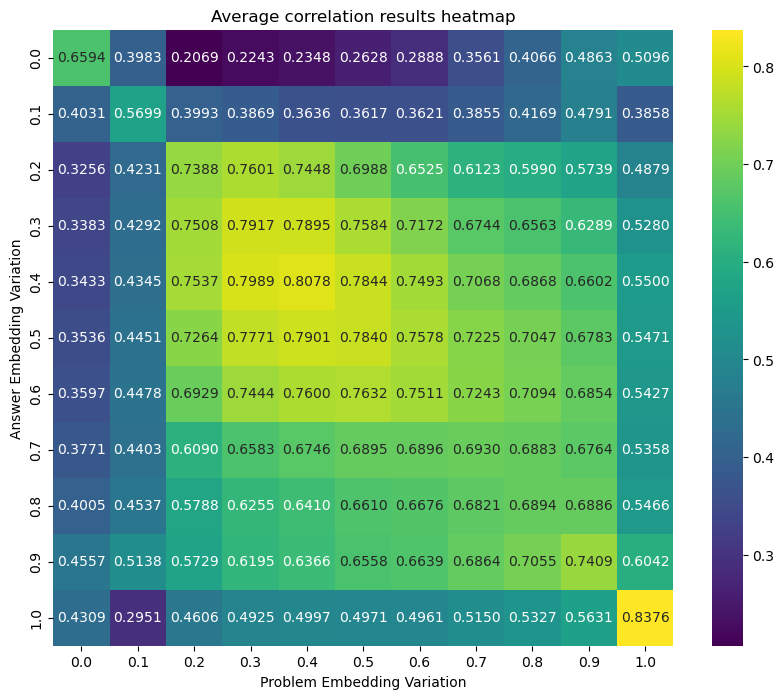

In [10]:
pivot_df = mean_df.pivot(
    index='answer_emb_variation',
    columns='problem_emb_variation',
    values='correlation'
)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap='viridis')

plt.title("Average correlation results heatmap")
plt.xlabel("Problem Embedding Variation")
plt.ylabel("Answer Embedding Variation")

plt.show()